# "아침"시간대 유동인구의 추세(Cycle) 성분 예측

# 1. import library

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
warnings.filterwarnings(action='ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils.preprocess_utils import *
from utils.train_utils import *

# 2. 데이터 불러오기

In [62]:
### morning data
with open('../data/preprocess/m_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)
data_list = append_cycle_size(data_list)
train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

# 3. 6가지 모델 훈련

In [63]:
trendcycle = 1
# trend일 때 0
# cycle일 때 1
tc_name = "cycle"
model_valid_scores = {f"linear_{tc_name}" : [],
                      f"svm_{tc_name}" : [],
                        f"xgboost_{tc_name}":[],
                         f"lstm_{tc_name}"   :[],
                          f"gru_{tc_name}"    :[],
                          f"lstm_fc_{tc_name}":[],}

## 1) Linear regression

In [64]:
from sklearn.linear_model import LinearRegression
model_name = f"linear_{tc_name}"

In [65]:
X = np.array(train_time[:,:,:].cpu()).reshape(-1,21*12)
y = np.array(train_y[:,:,trendcycle].cpu())
val_X = np.array(valid_time[:,:,:].cpu()).reshape(-1,21*12)
val_y = np.array(valid_y[:,:,trendcycle].cpu())

# fitting
multioutputregressor = MultiOutputRegressor(LinearRegression()).fit(X, y)
# predicting
train_mse = np.mean((multioutputregressor.predict(X) - y)**2)
valid_mse = np.mean((multioutputregressor.predict(val_X) - val_y)**2)
print("train_mse: ", train_mse)
print("valid_mse: ", valid_mse)
model_valid_scores[model_name] = valid_mse

with open(f'best_model/{model_name}.pkl', 'wb') as f:
    pickle.dump(multioutputregressor, f)

train_mse:  0.008944604
valid_mse:  0.04337886


## 2) SVM regressoion

In [66]:
from sklearn.svm import SVR
model_name =  f"svm_{tc_name}"

In [67]:
X = np.array(train_time[:,:,:].cpu()).reshape(-1,21*12)
y = np.array(train_y[:,:,trendcycle].cpu())
val_X = np.array(valid_time[:,:,:].cpu()).reshape(-1,21*12)
val_y = np.array(valid_y[:,:,trendcycle].cpu())

# fitting
multioutputregressor = MultiOutputRegressor(SVR()).fit(X, y)
# predicting
train_mse = np.mean((multioutputregressor.predict(X) - y)**2)
valid_mse = np.mean((multioutputregressor.predict(val_X) - val_y)**2)
print("train_mse: ", train_mse)
print("valid_mse: ", valid_mse)
model_valid_scores[model_name] = valid_mse

with open(f'best_model/{model_name}.pkl', 'wb') as f:
    pickle.dump(multioutputregressor, f)

train_mse:  0.004093312212698483
valid_mse:  0.034357363400698976


## 3) XGboost

In [68]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
model_name =  f"xgboost_{tc_name}"
            # trend일 때 0
            # cycle일 때 1

In [69]:
X = np.array(train_time[:,:,:].cpu()).reshape(-1,21*12)
y = np.array(train_y[:,:,trendcycle].cpu())
val_X = np.array(valid_time[:,:,:].cpu()).reshape(-1,21*12)
val_y = np.array(valid_y[:,:,trendcycle].cpu())

# fitting
multioutputregressor = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror')).fit(X, y)
# predicting
train_mse = np.mean((multioutputregressor.predict(X) - y)**2)
valid_mse = np.mean((multioutputregressor.predict(val_X) - val_y)**2)
print("train_mse: ", train_mse)
print("valid_mse: ", valid_mse)
model_valid_scores[model_name] = valid_mse

with open(f'best_model/{model_name}.pkl', 'wb') as f:
    pickle.dump(multioutputregressor, f)

train_mse:  9.900773e-05
valid_mse:  0.037455346


## 4) LSTM

In [70]:
from models.LSTM import LSTM
model = LSTM(input_size = 12, hidden_size = 32, no_time_size =4).to(device)
model_name = f"lstm_{tc_name}"

In [71]:
# Train model
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)
num_epochs  = 500
hist = np.zeros(num_epochs)
train_error = []
valid_error = []
hist = {'best_val_error': 100,
        'best_val_epoch': 0}
for t in range(num_epochs):
    train_trend_pred = model(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,trendcycle]) ### trend
    train_error.append(loss)
    valid_trend_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,trendcycle]).cpu()) ### trend
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, f'best_model/{model_name}.pkl')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
        
best_model = torch.load( f'best_model/{model_name}.pkl')
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,trendcycle]))
print('valid_error : ',criterion(valid_pred, valid_y[:,:,trendcycle]))
model_valid_scores[model_name] = float(criterion(valid_pred, valid_y[:,:,trendcycle]).cpu())

10 Epochs train MSE: 0.05495 // valid MSE: 0.05874
20 Epochs train MSE: 0.03615 // valid MSE: 0.05019
30 Epochs train MSE: 0.01866 // valid MSE: 0.04403
40 Epochs train MSE: 0.01321 // valid MSE: 0.04196
50 Epochs train MSE: 0.01031 // valid MSE: 0.04136
60 Epochs train MSE: 0.00826 // valid MSE: 0.04180
70 Epochs train MSE: 0.00737 // valid MSE: 0.04352
80 Epochs train MSE: 0.00654 // valid MSE: 0.04382
90 Epochs train MSE: 0.00591 // valid MSE: 0.04447
100 Epochs train MSE: 0.00536 // valid MSE: 0.04433
110 Epochs train MSE: 0.00484 // valid MSE: 0.04608
120 Epochs train MSE: 0.00441 // valid MSE: 0.04871
130 Epochs train MSE: 0.00405 // valid MSE: 0.04819
140 Epochs train MSE: 0.00369 // valid MSE: 0.05282
150 Epochs train MSE: 0.00332 // valid MSE: 0.05494
160 Epochs train MSE: 0.00303 // valid MSE: 0.05698
170 Epochs train MSE: 0.00281 // valid MSE: 0.06040
180 Epochs train MSE: 0.00295 // valid MSE: 0.06555
190 Epochs train MSE: 0.00257 // valid MSE: 0.06000
200 Epochs train MSE:

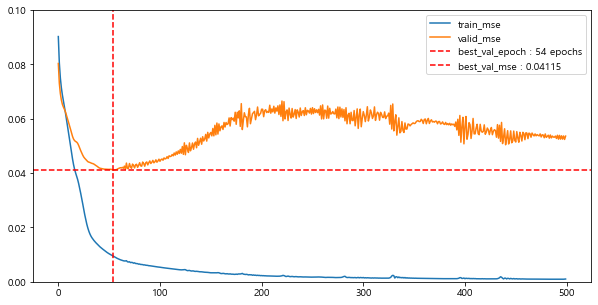

In [72]:
plot_hist(train_error, valid_error, hist, ylim = 0.1)

## 5) GRU

In [73]:
from models.GRU import GRU
model = GRU(input_size = 12, hidden_size = 32, no_time_size =4).to(device)
model_name =  f"gru_{tc_name}"

In [74]:
# Train model
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)
num_epochs  = 500
hist = np.zeros(num_epochs)
train_error = []
valid_error = []
hist = {'best_val_error': 100,
        'best_val_epoch': 0}
for t in range(num_epochs):
    train_trend_pred = model(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,trendcycle]) ### trend
    train_error.append(loss)
    valid_trend_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,trendcycle]).cpu()) ### trend
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, f'best_model/{model_name}.pkl')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
        
best_model = torch.load( f'best_model/{model_name}.pkl')
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,trendcycle]))
print('valid_error : ',criterion(valid_pred, valid_y[:,:,trendcycle]))
model_valid_scores[model_name] = float(criterion(valid_pred, valid_y[:,:,trendcycle]).cpu())

10 Epochs train MSE: 0.05824 // valid MSE: 0.06120
20 Epochs train MSE: 0.04389 // valid MSE: 0.05387
30 Epochs train MSE: 0.02950 // valid MSE: 0.04557
40 Epochs train MSE: 0.01742 // valid MSE: 0.04327
50 Epochs train MSE: 0.01292 // valid MSE: 0.04457
60 Epochs train MSE: 0.01051 // valid MSE: 0.04676
70 Epochs train MSE: 0.00887 // valid MSE: 0.04645
80 Epochs train MSE: 0.00777 // valid MSE: 0.04738
90 Epochs train MSE: 0.00726 // valid MSE: 0.04811
100 Epochs train MSE: 0.00664 // valid MSE: 0.04746
110 Epochs train MSE: 0.00624 // valid MSE: 0.04766
120 Epochs train MSE: 0.00587 // valid MSE: 0.04919
130 Epochs train MSE: 0.00555 // valid MSE: 0.04935
140 Epochs train MSE: 0.00537 // valid MSE: 0.04703
150 Epochs train MSE: 0.00503 // valid MSE: 0.04897
160 Epochs train MSE: 0.00471 // valid MSE: 0.04878
170 Epochs train MSE: 0.00442 // valid MSE: 0.04911
180 Epochs train MSE: 0.00417 // valid MSE: 0.04997
190 Epochs train MSE: 0.00420 // valid MSE: 0.05067
200 Epochs train MSE:

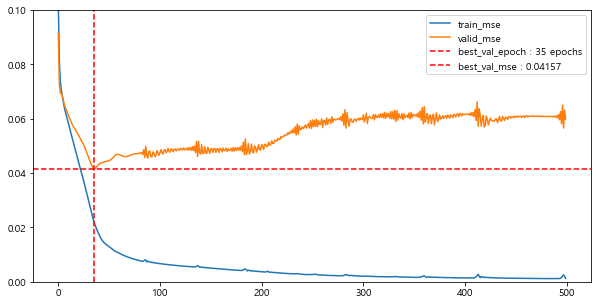

In [75]:
plot_hist(train_error, valid_error, hist, ylim = 0.1)

## 6) LSTM, FC 결합 모델

In [76]:
from models.LSTM_FC_cycle import LSTM_FC_cycle
model = LSTM_FC_cycle(input_size = 12, hidden_size = 32, no_time_size =4).to(device)
model_name = f'lstm_fc_{tc_name}'

In [77]:
# Train model
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = nn.MSELoss(size_average = True)
num_epochs  = 200
hist = np.zeros(num_epochs)
train_error = []
valid_error = []
hist = {'best_val_error': 100,
        'best_val_epoch': 0}
for t in range(num_epochs):
    train_trend_pred = model(train_time, train_notime)
    loss = criterion(train_trend_pred, train_y[:,:,trendcycle]) ### trend
    train_error.append(loss)
    valid_trend_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_trend_pred, valid_y[:,:,trendcycle]).cpu()) ### trend
    valid_error.append(valid_mse)
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        torch.save(model, f'best_model/{model_name}.pkl')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")
        
best_model = torch.load( f'best_model/{model_name}.pkl')
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
print('train_error : ',criterion(train_pred, train_y[:,:,trendcycle]))
print('valid_error : ',criterion(valid_pred, valid_y[:,:,trendcycle]))
model_valid_scores[model_name] = float(criterion(valid_pred, valid_y[:,:,trendcycle]).cpu())

10 Epochs train MSE: 0.14605 // valid MSE: 0.11815
20 Epochs train MSE: 0.08258 // valid MSE: 0.07386
30 Epochs train MSE: 0.07843 // valid MSE: 0.07174
40 Epochs train MSE: 0.06985 // valid MSE: 0.06732
50 Epochs train MSE: 0.05462 // valid MSE: 0.05840
60 Epochs train MSE: 0.04409 // valid MSE: 0.05298
70 Epochs train MSE: 0.03544 // valid MSE: 0.04806
80 Epochs train MSE: 0.02540 // valid MSE: 0.04376
90 Epochs train MSE: 0.01914 // valid MSE: 0.04267
100 Epochs train MSE: 0.01541 // valid MSE: 0.04291
110 Epochs train MSE: 0.01335 // valid MSE: 0.04257
120 Epochs train MSE: 0.01206 // valid MSE: 0.04259
130 Epochs train MSE: 0.01123 // valid MSE: 0.04256
140 Epochs train MSE: 0.01019 // valid MSE: 0.04212
150 Epochs train MSE: 0.00911 // valid MSE: 0.04205
160 Epochs train MSE: 0.00815 // valid MSE: 0.04201
170 Epochs train MSE: 0.00732 // valid MSE: 0.04093
180 Epochs train MSE: 0.00634 // valid MSE: 0.04133
190 Epochs train MSE: 0.00599 // valid MSE: 0.04279
train_error :  tensor

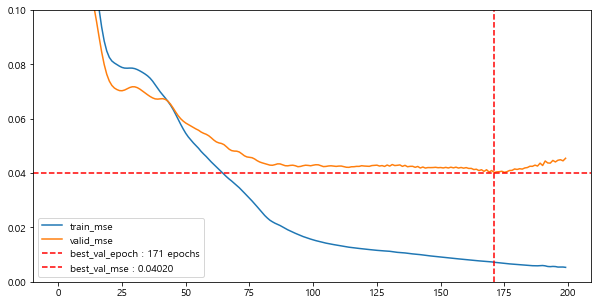

In [78]:
plot_hist(train_error, valid_error, hist, ylim = 0.1)

# 4. 6가지 모델의 검증데이터 성능 비교

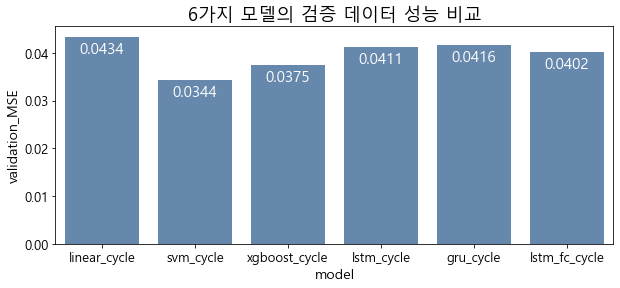

In [79]:
model_valid_scores = pd.DataFrame({"model"  : list(model_valid_scores.keys()),
                                    "validation_MSE": list(model_valid_scores.values())})
plot_models_valid_mse(model_valid_scores)
best_model_name = model_valid_scores.sort_values("validation_MSE").iloc[0]['model']

# 5. 훈련 데이터와 검증 데이터의 성능 비교

In [80]:
try:
    best_model = torch.load( f'best_model/{best_model_name}.pkl')
except:
    with open( f'best_model/{best_model_name}.pkl', 'rb') as f:
        best_model = pickle.load(f)

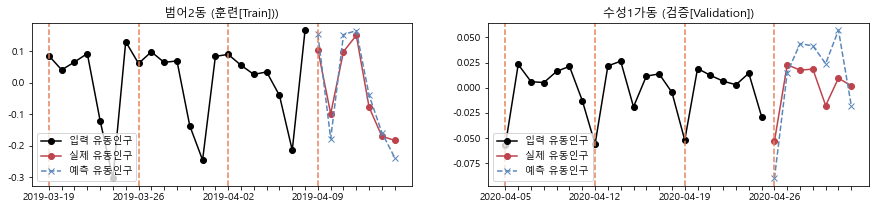

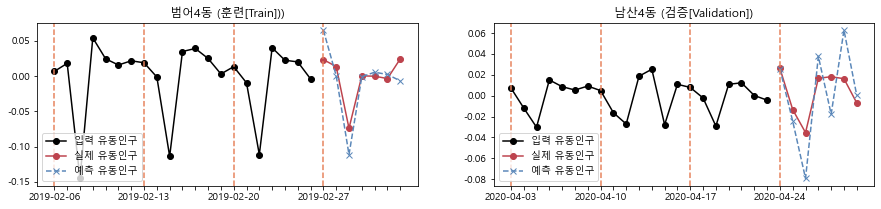

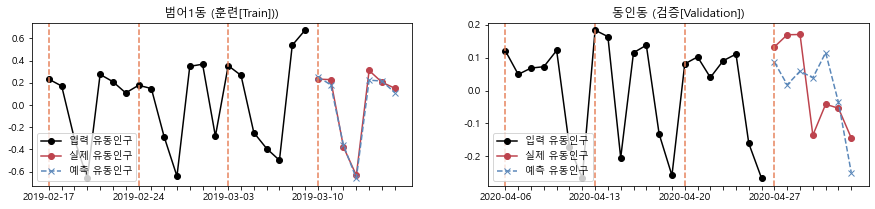

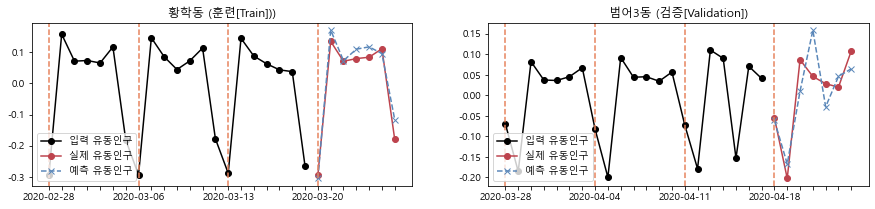

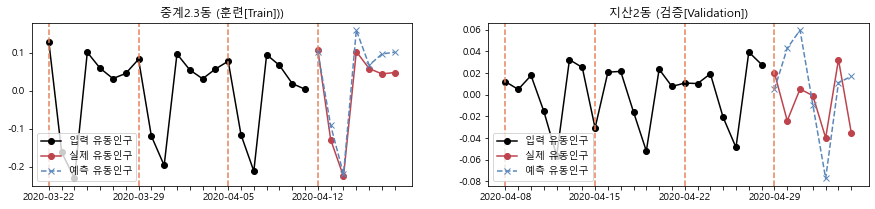

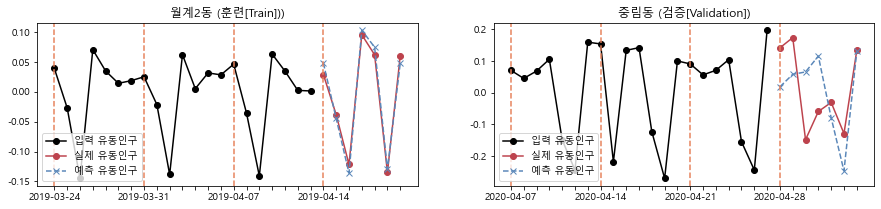

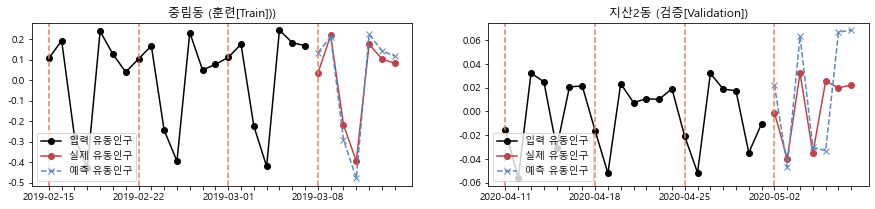

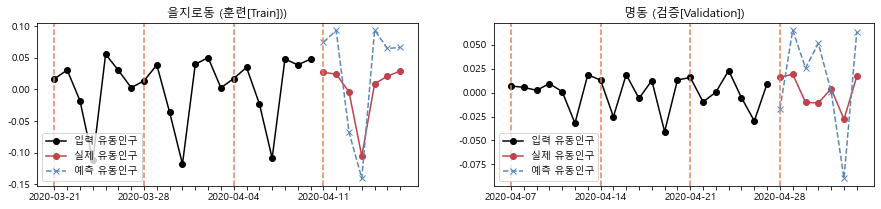

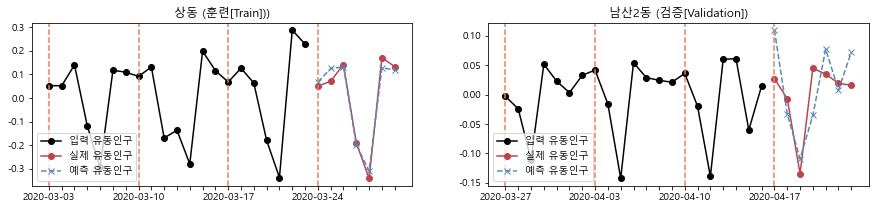

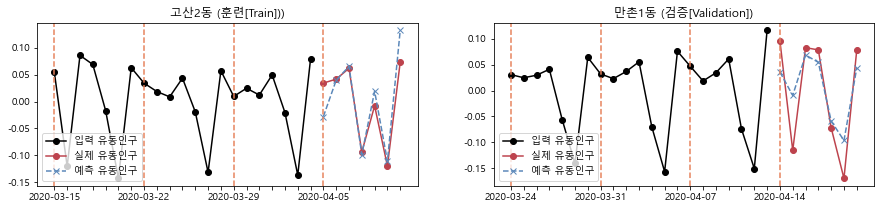

In [81]:
try:
    valid_trend_pred = best_model(valid_time, valid_notime)
    train_trend_pred = best_model(train_time, train_notime)
    
    train_x_np, train_y_np, train_pred_np,\
    valid_time_x_np, valid_y_np, valid_pred_np= tensor2numpy([train_time[:,:,trendcycle-2], train_y[:,:,trendcycle], train_trend_pred,
                                                            valid_time[:,:,trendcycle-2], valid_y[:,:,trendcycle], valid_trend_pred])
except:
    X = np.array(train_time[:,:,:].cpu()).reshape(-1,21*12)
    y = np.array(train_y[:,:,trendcycle].cpu())
    val_X = np.array(valid_time[:,:,:].cpu()).reshape(-1,21*12)
    val_y = np.array(valid_y[:,:,trendcycle].cpu())
    
    train_pred = best_model.predict(X)
    valid_pred = best_model.predict(val_X)
    
    train_x_np, train_y_np, train_pred_np,\
    valid_time_x_np, valid_y_np, valid_pred_np = np.array(train_time[:,:,trendcycle-2].cpu()).reshape(-1,21), y, train_pred,\
                                                  np.array(valid_time[:,:,trendcycle-2].cpu()).reshape(-1,21), val_y, valid_pred, 
    
plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

trend_result_list = [train_x_np, train_y_np, train_pred_np,\
    valid_time_x_np, valid_y_np, valid_pred_np]

### morning result
path = '../data/train_results/morning_results/'
with open(path + 'm_cycle_results_list.pkl', 'wb') as f:
    pickle.dump(trend_result_list, f)

# 6. 평가(test set)

In [82]:
try:
    test_pred = best_model(test_time, test_notime)
    print('test_error : ',criterion(test_pred, test_y[:,:,trendcycle]))
except:
    test_x = np.array(test_time[:,:,:].cpu()).reshape(-1,21*12)
    test_pred = best_model.predict(test_x)
    print('test_error : ',np.mean(((test_pred) - (np.array(test_y[:,:,trendcycle].cpu())))**2))

test_error :  0.0358151314791496


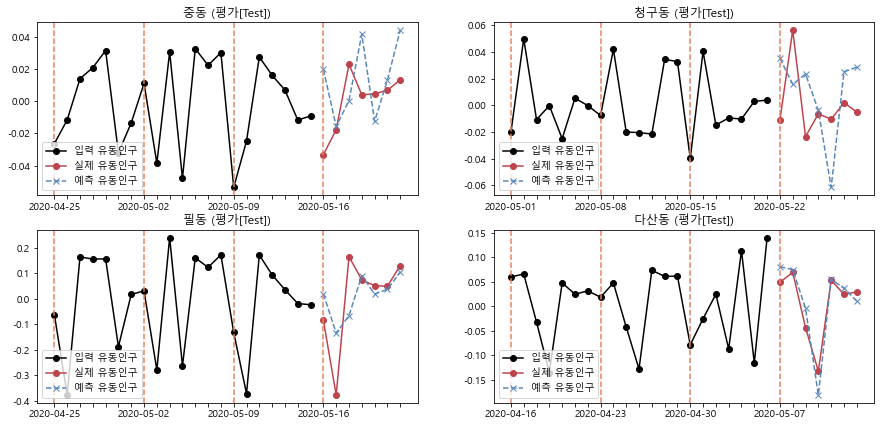

In [83]:
try:
    test_pred = best_model(test_time, test_notime)
    test_time_x_np, test_y_np, test_pred_np = tensor2numpy([test_time[:,:,trendcycle-2], test_y[:,:,trendcycle], test_pred])
except:
    testX, test_time_x_np, test_y_np = tensor2numpy([test_time, test_time[:,:,trendcycle-2], test_y[:,:,trendcycle]])
    test_pred_np = best_model.predict(testX.reshape(-1,21*12))

# plot result
plot_test_predict(test_time_x_np, test_y_np, test_pred_np)

# save result
trend_result_list = [test_time_x_np, test_y_np, test_pred_np]
path = '../data/train_results/morning_results/'
with open(path + 'm_cycle_results_test.pkl', 'wb') as f:
    pickle.dump(trend_result_list, f)

# 7. 6월 유동인구 주기(Cycle) 성분 예측

In [85]:
with open('../data/predict_june/preprocess_june/morning_june_time.pkl', 'rb') as f:
    train_time = pickle.load(f)
with open('../data/predict_june/preprocess_june/morning_june_notime.pkl', 'rb') as f:
    train_notime = pickle.load(f)

cycle_size =train_time[:,:,-2].max(axis = 1) - train_time[:,:, -2].min(axis = 1)
train_notime = np.concatenate([train_notime, cycle_size.reshape(-1,1)], axis = 1)

try:
    train_time_x, train_notime_x = numpy2tensor([train_time[:,:,3:].astype(np.float64), train_notime.astype(np.float64)])
    pred_y = best_model(train_time_x, train_notime_x)
    pred_y = np.array(pred_y.cpu().detach())
except:
    pred_y = best_model.predict(train_time[:,:,3:].astype(np.float64).reshape(-1,21*12))



path = '../data/predict_june/predict_cycle_trend/'
with open(path + 'june_morning_cycle_pred.pkl', 'wb') as f:
    pickle.dump(pred_y, f)